原始数据形状: (768, 9)
人工记录形状: (10000, 9)
合并后的数据形状: (10768, 9)
ReliefF 计算的特征重要性排序： ['DiabetesPedigreeFunction', 'Age', 'BMI', 'BloodPressure', 'Pregnancies', 'Glucose', 'Insulin', 'SkinThickness']
自动生成的区域映射：
DiabetesPedigreeFunction: (0, 0, 80, 80)
Age: (80, 0, 40, 60)
BMI: (0, 80, 50, 40)
BloodPressure: (50, 80, 40, 30)
Pregnancies: (80, 60, 40, 20)
Glucose: (90, 80, 30, 20)
Insulin: (50, 110, 25, 10)
SkinThickness: (75, 110, 20, 10)


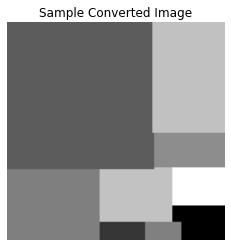


---------------- Fold 1 ----------------
训练集样本数: 10614
测试集样本数: 154
Fold 1 - Epoch 1/20 - Loss: 0.5426 - Train Acc: 71.22% - Test Acc: 79.87%
Fold 1 - Epoch 2/20 - Loss: 0.4156 - Train Acc: 80.55% - Test Acc: 81.82%
Fold 1 - Epoch 3/20 - Loss: 0.3668 - Train Acc: 83.09% - Test Acc: 80.52%
Fold 1 - Epoch 4/20 - Loss: 0.3280 - Train Acc: 84.99% - Test Acc: 84.42%
Fold 1 - Epoch 5/20 - Loss: 0.2942 - Train Acc: 86.51% - Test Acc: 85.71%
Fold 1 - Epoch 6/20 - Loss: 0.2797 - Train Acc: 87.31% - Test Acc: 88.31%
Fold 1 - Epoch 7/20 - Loss: 0.2447 - Train Acc: 89.06% - Test Acc: 92.86%
Fold 1 - Epoch 8/20 - Loss: 0.2197 - Train Acc: 90.47% - Test Acc: 92.21%
Fold 1 - Epoch 9/20 - Loss: 0.2103 - Train Acc: 90.95% - Test Acc: 93.51%
Fold 1 - Epoch 10/20 - Loss: 0.1829 - Train Acc: 92.24% - Test Acc: 92.86%
Fold 1 - Epoch 11/20 - Loss: 0.1692 - Train Acc: 92.92% - Test Acc: 92.21%
Fold 1 - Epoch 12/20 - Loss: 0.1457 - Train Acc: 94.19% - Test Acc: 92.86%
Fold 1 - Epoch 13/20 - Loss: 0.1357 - Tra

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

# ===================== Artificial Record 数据处理 =====================
def create_artificial_records(dataset, num_artificial_records=10000):
    artificial_records = []
    
    # 将数据按 Outcome 分为糖尿病和非糖尿病
    diabetic = dataset[dataset[:, -1] == 1]
    non_diabetic = dataset[dataset[:, -1] == 0]
    
    for partition in [diabetic, non_diabetic]:
        # 根据年龄分组：小于40为年轻组，大于等于40为年长组
        young = partition[partition[:, -2] < 40]
        old = partition[partition[:, -2] >= 40]
        
        for age_group in [young, old]:
            # 分为孕妇组和非孕妇组（孕次>0为孕妇）
            pregnant = age_group[age_group[:, 0] > 0]
            non_pregnant = age_group[age_group[:, 0] == 0]
            
            for group in [pregnant, non_pregnant]:
                if len(group) > 0:  # 确保组非空
                    for _ in range(num_artificial_records // 8):
                        new_record = group[np.random.randint(len(group))].copy()
                        
                        # 在 Glucose 和 Insulin 上做微小调整（保持反比关系）
                        glucose_change = np.random.uniform(-10, 10)
                        new_record[1] += glucose_change
                        new_record[4] -= glucose_change * 0.5
                        
                        # 在 SkinThickness 和 BMI 上做微小调整
                        skin_change = np.random.uniform(-5, 5)
                        new_record[3] += skin_change
                        new_record[5] += skin_change * 0.1
                        
                        artificial_records.append(new_record)
    
    return np.array(artificial_records)

# 设置随机种子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ---------------------- 0. 数据加载与清洗 ----------------------
# 假设文件中列顺序为：Pregnancies, Glucose, BloodPressure, SkinThickness,
# Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
data = pd.read_csv('diabetes_dataset_1.csv')

# 将部分特征中可能出现的0（视为缺失值）替换为中位数
cols_to_replace = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_to_replace:
    data[col] = data[col].replace(0, np.nan)
    data[col].fillna(data[col].median(), inplace=True)

# ---------------------- 1. 生成原始数据与人工记录，并合并数据 ----------------------
# 将原始数据转换为 numpy 数组
dataset_np = data.values
print("原始数据形状:", dataset_np.shape)

# 生成人工记录（基于原始数据生成）
artificial_dataset = create_artificial_records(dataset_np)
print("人工记录形状:", artificial_dataset.shape)

# 合并原始数据和部分人工记录（此处只取前 10000 条人工记录）
combined_dataset_np = np.vstack((dataset_np, artificial_dataset[:10000]))
print("合并后的数据形状:", combined_dataset_np.shape)

# 转换为 DataFrame，并保持原有列名
combined_data = pd.DataFrame(combined_dataset_np, columns=data.columns)

# ---------------------- 2. 对所有特征进行 min–max 归一化 ----------------------
# 仅对特征列归一化，Outcome 保持不变
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

data_norm = combined_data.copy()
for col in feature_cols:
    min_val = data_norm[col].min()
    max_val = data_norm[col].max()
    data_norm[col] = (data_norm[col] - min_val) / (max_val - min_val)

# ---------------------- 3. 利用 ReliefF 计算特征重要性 ----------------------
from skrebate import ReliefF

X = data_norm[feature_cols].values
y = data_norm['Outcome'].values.astype(int)

relief = ReliefF(n_neighbors=10)
relief.fit(X, y)
importance_scores = relief.feature_importances_

# 按重要性降序排列，得到特征名称排序
ordered_indices = np.argsort(importance_scores)[::-1]
ordered_features = [feature_cols[i] for i in ordered_indices]
print("ReliefF 计算的特征重要性排序：", ordered_features)

# ---------------------- 4. 根据排序自动生成区域映射 ----------------------
predefined_regions = [
    (0, 0, 80, 80),    # 面积：6400
    (80, 0, 40, 60),   # 面积：2400
    (0, 80, 50, 40),   # 面积：2000
    (50, 80, 40, 30),  # 面积：1200
    (80, 60, 40, 20),  # 面积：800
    (90, 80, 30, 20),  # 面积：600
    (50, 110, 25, 10), # 面积：250
    (75, 110, 20, 10)  # 面积：200
]

self_region_mapping = {
    "Age": (0, 0, 69, 60),
    "SkinThickness": (69, 0, 51, 60),
    "BMI": (0, 60, 59, 40),
    "Pregnancies": (59, 60, 32, 40),
    "Insulin": (91, 60, 29, 40),
    "DiabetesPedigreeFunction": (0, 100, 75, 20),
    "BloodPressure": (75, 100, 39, 20),
    "Glucose": (114, 100, 6, 20)
}

auto_region_mapping = {}
for i, feat in enumerate(ordered_features):
    auto_region_mapping[feat] = predefined_regions[i]

print("自动生成的区域映射：")
for feat, region in auto_region_mapping.items():
    print(f"{feat}: {region}")

# ---------------------- 5. 数值到图像转换函数 ----------------------
def create_image_from_features(sample, region_mapping):
    """
    根据单个样本的归一化特征和指定 region_mapping 生成 120x120 灰度图像
    """
    img = Image.new('L', (120, 120), color=0)
    draw = ImageDraw.Draw(img)
    
    for feat in feature_cols:
        val = int(sample[feat] * 255)
        if feat in region_mapping:
            x, y, w, h = region_mapping[feat]
            draw.rectangle([x, y, x + w, y + h], fill=val)
    return img

# 可视化转换后的图像示例
sample_img = create_image_from_features(data_norm.iloc[0], auto_region_mapping)
plt.imshow(sample_img, cmap='gray')
plt.title("Sample Converted Image")
plt.axis('off')
plt.show()

# ---------------------- 6. 定义 PyTorch 数据集 ----------------------
class PimaImageDataset(Dataset):
    def __init__(self, df, transform=None, region_mapping=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.region_mapping = region_mapping if region_mapping is not None else auto_region_mapping

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        img = create_image_from_features(sample, self.region_mapping)
        label = int(float(sample['Outcome']))
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, label

# ---------------------- 7. 数据增强与数据加载器 ----------------------
def convert_to_rgb(img):
    return img.convert('RGB')

train_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ---------------------- 8. 五折交叉验证 ----------------------
# 注意：这里仍然保持原有目标——测试集仅来自原始数据，人工记录始终加入训练
original_data_norm = data_norm.iloc[:dataset_np.shape[0]]
artificial_data_norm = data_norm.iloc[dataset_np.shape[0]:]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_idx = 1
fold_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for train_index, test_index in skf.split(original_data_norm, original_data_norm['Outcome']):
    print(f"\n---------------- Fold {fold_idx} ----------------")
    # 当前折中原始数据的训练和测试部分
    train_original_fold = original_data_norm.iloc[train_index]
    test_original_fold = original_data_norm.iloc[test_index]
    
    # 训练集由当前折的原始数据和所有人工记录组成
    train_df_fold = pd.concat([train_original_fold, artificial_data_norm], ignore_index=True)
    test_df_fold = test_original_fold
    
    print("训练集样本数:", train_df_fold.shape[0])
    print("测试集样本数:", test_df_fold.shape[0])
    
    train_dataset = PimaImageDataset(train_df_fold, transform=train_transform, region_mapping=auto_region_mapping)
    test_dataset = PimaImageDataset(test_df_fold, transform=test_transform, region_mapping=auto_region_mapping)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # ---------------------- 9. 定义并微调预训练的 ResNet18 模型 ----------------------
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 二分类任务
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
        
        epoch_loss = running_loss / total_train
        train_acc = correct_train / total_train * 100
        
        # 在当前折测试集上评估
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (preds == labels).sum().item()
        test_loss = running_test_loss / total_test
        test_acc = correct_test / total_test * 100
        
        print(f"Fold {fold_idx} - Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")
    
    # 记录当前折的最终测试准确率
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    final_test_acc = correct / total * 100
    print(f"Fold {fold_idx} Final Test Accuracy: {final_test_acc:.2f}%")
    fold_accuracies.append(final_test_acc)
    
    fold_idx += 1

print("\n---------------- Cross Validation Results ----------------")
for i, acc in enumerate(fold_accuracies, 1):
    print(f"Fold {i}: Test Accuracy = {acc:.2f}%")
print(f"Average Test Accuracy: {np.mean(fold_accuracies):.2f}%")
